# OJT Project

### ✅ Step 1: Define All Demographic & Policy Value Options

In [1]:
import itertools
import pandas as pd
import random

# Define all realistic values
premium_terms = [5, 10, 15, 20, 25]
genders = ["Male", "Female"]
income_groups = ["<3L", "3–6L", "6–10L", "10L+"]
occupations = ["Farmer", "Clerk", "Business Owner", "Teacher", "Self-employed", "Engineer"]
marital_statuses = ["Single", "Married", "Widowed"]
locations = ["Urban", "Semi-urban", "Rural"]
children_options = ["Yes", "No"]
benefit_terms = [10, 15, 20, 25, 30]  # These will be assigned randomly later


### ✅ Step 2: Generate All Combinations (Except Benefit Term)

In [2]:
# Create all combinations using itertools.product
combinations = list(itertools.product(
    premium_terms,
    genders,
    income_groups,
    occupations,
    marital_statuses,
    locations,
    children_options
))

# Convert to DataFrame
columns = ['Premium_Term', 'Gender', 'Income', 'Occupation',
           'Marital_Status', 'Location', 'Children']

df_combinations = pd.DataFrame(combinations, columns=columns)

# Preview
df_combinations.head()


,Premium_Term,Gender,Income,Occupation,Marital_Status,Location,Children
0,5,Male,<3L,Farmer,Single,Urban,Yes
1,5,Male,<3L,Farmer,Single,Urban,No
2,5,Male,<3L,Farmer,Single,Semi-urban,Yes
3,5,Male,<3L,Farmer,Single,Semi-urban,No
4,5,Male,<3L,Farmer,Single,Rural,Yes


### ✅ Step 3: Randomly Assign Benefit Terms to Each Combination

In [3]:
# Define possible benefit terms again
benefit_terms = [10, 15, 20, 25, 30]

# Randomly assign a benefit term to each combination
df_combinations['Benefit_Term'] = [random.choice(benefit_terms) for _ in range(len(df_combinations))]

# Assign benefit term based on premium term (not totally random)
def assign_benefit(premium):
    mapping = {
        5: [10, 15],
        10: [15, 20],
        15: [20, 25],
        20: [25, 30],
        25: [25, 30]
    }
    return random.choice(mapping[premium])

df_combinations['Benefit_Term'] = df_combinations['Premium_Term'].apply(assign_benefit)


# Duplicate some rows to increase dataset size 
df_combinations = pd.concat([df_combinations]*5, ignore_index = True)

# Save to csv dataset
df_combinations.to_csv("Demographic_Combinations.csv", index=False)

# Preview the updated DataFrame
df_combinations.head()


,Premium_Term,Gender,Income,Occupation,Marital_Status,Location,Children,Benefit_Term
0,5,Male,<3L,Farmer,Single,Urban,Yes,15
1,5,Male,<3L,Farmer,Single,Urban,No,15
2,5,Male,<3L,Farmer,Single,Semi-urban,Yes,15
3,5,Male,<3L,Farmer,Single,Semi-urban,No,15
4,5,Male,<3L,Farmer,Single,Rural,Yes,15


### ✅ Step 4: Convert to Apriori-Compatible Transactions

In [4]:
# Label encoding for each column
df_combinations['Premium_Label'] = 'Premium_' + df_combinations['Premium_Term'].astype(str)
df_combinations['Gender_Label'] = 'Gender_' + df_combinations['Gender']
df_combinations['Income_Label'] = 'Income_' + df_combinations['Income']
df_combinations['Occupation_Label'] = 'Occupation_' + df_combinations['Occupation']
df_combinations['Marital_Label'] = 'Marital_' + df_combinations['Marital_Status']
df_combinations['Location_Label'] = 'Location_' + df_combinations['Location']
df_combinations['Children_Label'] = 'Children_' + df_combinations['Children']
df_combinations['Benefit_Label'] = 'Benefit_' + df_combinations['Benefit_Term'].astype(str)

# Select only the labeled columns
labeled_cols = [
    'Premium_Label', 'Gender_Label', 'Income_Label',
    'Occupation_Label', 'Marital_Label', 'Location_Label',
    'Children_Label', 'Benefit_Label'
]

# Convert each row into a transaction (list of items)
transactions = df_combinations[labeled_cols].values.tolist()

# Preview first 3 transactions
for t in transactions[:3]:
    print(t)


['Premium_5', 'Gender_Male', 'Income_<3L', 'Occupation_Farmer', 'Marital_Single', 'Location_Urban', 'Children_Yes', 'Benefit_15']
['Premium_5', 'Gender_Male', 'Income_<3L', 'Occupation_Farmer', 'Marital_Single', 'Location_Urban', 'Children_No', 'Benefit_15']
['Premium_5', 'Gender_Male', 'Income_<3L', 'Occupation_Farmer', 'Marital_Single', 'Location_Semi-urban', 'Children_Yes', 'Benefit_15']


### ✅ Step 5: Apply the Apriori Algorithm to Generate Association Rules

In [5]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Step 1: Convert list of transactions to encoded DataFrame
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Step 2: Generate frequent itemsets (lower min_support for synthetic data)
frequent_itemsets = apriori(df_encoded, min_support=0.001, use_colnames=True)

# Step 3: Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

# Step 4: Filter rules where antecedents contain Premium_ and consequents contain Benefit_
filtered_rules = rules[
    rules['antecedents'].apply(lambda x: any(item.startswith('Premium_') for item in x)) &
    rules['consequents'].apply(lambda x: any(item.startswith('Benefit_') for item in x))
]

# Step 5: Preview results
print("=== Filtered Association Rules (Premium → Benefit) ===")
print(filtered_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

# Save the filtered rules to a CSV file
filtered_rules.to_csv("filtered_rules.csv", index=False)

print("✅ filtered_rules.csv saved successfully.")


=== Filtered Association Rules (Premium → Benefit) ===
                                           antecedents   consequents  \
21                     (Premium_25, Occupation_Farmer)  (Benefit_30)   
145        (Income_10L+, Premium_5, Occupation_Farmer)  (Benefit_10)   
155  (Premium_5, Occupation_Business Owner, Income_...  (Benefit_10)   
170     (Premium_5, Occupation_Engineer, Income_6–10L)  (Benefit_10)   
235              (Income_<3L, Premium_5, Children_Yes)  (Benefit_15)   

      support  confidence      lift  
21   0.020139    0.604167  2.890365  
145  0.005093    0.611111  6.346154  
155  0.005093    0.611111  6.346154  
170  0.005093    0.611111  6.346154  
235  0.015278    0.611111  3.052023  
✅ filtered_rules.csv saved successfully.


### Chart of confidence and lift by Premium

C:\Users\INDIA\AppData\Local\Temp\ipykernel_3608\1239399586.py:34: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


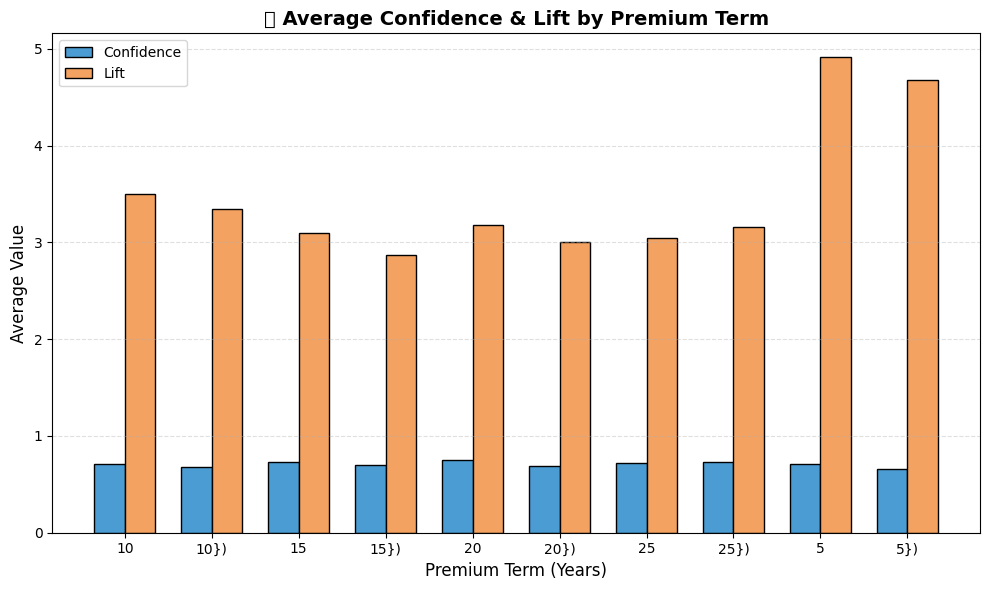

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load the rules if not already loaded
filtered_rules = pd.read_csv("filtered_rules.csv")

# ✅ Extract Premium_Term from antecedents
def extract_premium(antecedent_str):
    items = antecedent_str.strip("{}").replace("'", "").split(", ")
    for item in items:
        if item.startswith("Premium_"):
            return item.replace("Premium_", "")
    return None

filtered_rules['Premium_Term'] = filtered_rules['antecedents'].apply(extract_premium)

# 🔁 Plot the chart
agg = filtered_rules.groupby('Premium_Term')[['confidence', 'lift']].mean().reset_index()
x = np.arange(len(agg['Premium_Term']))

plt.figure(figsize=(10, 6))
bar_width = 0.35

plt.bar(x - bar_width/2, agg['confidence'], bar_width, color='#4B9CD3', label='Confidence', edgecolor='black')
plt.bar(x + bar_width/2, agg['lift'], bar_width, color='#F4A261', label='Lift', edgecolor='black')

plt.xticks(x, agg['Premium_Term'])
plt.xlabel("Premium Term (Years)", fontsize=12)
plt.ylabel("Average Value", fontsize=12)
plt.title("📊 Average Confidence & Lift by Premium Term", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


### Create GUI App for Recommendation model

In [7]:
import tkinter as tk
import ttkbootstrap as ttk
from ttkbootstrap import Style
from ttkbootstrap.constants import *
import pandas as pd
import datetime
import os

# Load rules
rules = pd.read_csv("filtered_rules.csv")

# Extract Premium_Term from antecedents
def extract_premium(antecedent_str):
    items = antecedent_str.strip("{}").replace("'", "").split(", ")
    for item in items:
        if item.startswith("Premium_"):
            return item.replace("Premium_", "")
    return None

rules['Premium_Term'] = rules['antecedents'].apply(extract_premium)

# GUI function
def recommendation_gui_from_notebook():
    root = tk.Tk()
    style = Style("superhero")
    root.title("PolicyMatch - Recommender")
    root.geometry("900x720")
    root.resizable(True, True)

    # Input Fields
    fields = {
        "Premium Term (years)": [5, 7, 8, 10, 15, 20, 25, 30, 40],
        "Gender": ["Male", "Female"],
        "Income Group": ["<3L", "3–6L", "6–10L", "10L+"],
        "Occupation": ["Farmer", "Clerk", "Business Owner", "Teacher", "Self-employed", "Engineer"],
        "Marital Status": ["Single", "Married", "Widowed"],
        "Location": ["Urban", "Semi-urban", "Rural"],
        "Children": ["Yes", "No"]
    }

    inputs = {}
    form_frame = ttk.Frame(root, padding=10)
    form_frame.pack()

    for label, options in fields.items():
        ttk.Label(form_frame, text=label + ":", font=("Segoe UI", 11)).pack(anchor="w", pady=2)
        cb = ttk.Combobox(form_frame, values=options)
        cb.pack(fill="x", pady=2)
        inputs[label] = cb

    use_lift = tk.BooleanVar()
    ttk.Checkbutton(form_frame, text="Use Lift instead of Confidence", variable=use_lift).pack(pady=5)

    output_text = tk.Text(root, height=12, width=110, font=("Consolas", 10))
    output_text.pack(pady=10)

    def get_recommendations():
        output_text.delete("1.0", tk.END)
        filters = []

        premium_val = inputs["Premium Term (years)"].get()
        if not premium_val:
            output_text.insert(tk.END, "⚠️ Please select a Premium Term.\n")
            return
        filters.append(f"Premium_{premium_val}")

        for label, cb in inputs.items():
            if label != "Premium Term (years)" and cb.get():
                filters.append(f"{label.replace(' ', '_').replace('(', '').replace(')', '')}_{cb.get()}")

        matched_rules = rules[rules['antecedents'].apply(lambda x: any(f in x for f in filters))]
        sort_metric = 'lift' if use_lift.get() else 'confidence'
        matched_rules = matched_rules.sort_values(by=sort_metric, ascending=False)

        os.makedirs("logs", exist_ok=True)
        with open("logs/recommendation_log.csv", "a") as log_file:
            timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            log_file.write(f"{timestamp},{'|'.join(filters)}\n")

        if matched_rules.empty:
            output_text.insert(tk.END, "❌ No matching recommendations found.\n")
        else:
            output_text.insert(tk.END, f"✅ Top 3 Recommendations (sorted by {sort_metric}):\n\n")
            for i, (_, row) in enumerate(matched_rules.head(3).iterrows(), 1):
                rule_text = (
                    f"{i}. If {set(eval(row['antecedents']))} → Then {set(eval(row['consequents']))}\n"
                    f"   Confidence: {row['confidence']:.2f}, Lift: {row['lift']:.2f}\n"
                    f"   Explanation: Based on similar customer profiles, this benefit is preferred.\n\n"
                )
                output_text.insert(tk.END, rule_text)

    ttk.Button(root, text="Get Recommendations", command=get_recommendations).pack(pady=10)
    root.mainloop()

# Run the GUI
recommendation_gui_from_notebook()
